# Library Declerations

In [1]:

import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Dropout,Activation
from keras.layers import LSTM, GRU
from sklearn.utils import shuffle
from keras.layers import Flatten    
import tensorflow as tf
from keras import losses
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error ,mean_absolute_error

Using TensorFlow backend.


# Importing Data and selecting columns

In [2]:
df=pd.read_csv("Oil and Gas 1932-2014.csv",parse_dates=['year'])
df.replace(np.nan,0,inplace=True)
data=df.groupby('year').sum().reset_index()
data1=pd.DataFrame(data[['oil_value_2014','gas_value_nom','oil_price_nom','oil_gas_value_2014','oil_value_nom','gas_prod55_14','gas_value_2014','mult_nom_2014']])


In [3]:
def series_to_supervised(data1, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data1) is list else data1.shape[1]
	df = DataFrame(data1)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
values = data1.values
print(values.shape)
values = values.astype('float32')
series_to_supervised(values,1,1).head()

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

values = reframed.values
n_train = 60 
train = values[:n_train]
test = values[n_train:]
Xtrain,Ytrain = train[:,:-1],train[:,-1]
Xtest,Ytest = test[:,:-1],test[:,-1]

Xtrain=Xtrain.reshape((Xtrain.shape[0],1,Xtrain.shape[1]))
Xtest=Xtest.reshape((Xtest.shape[0],1,Xtest.shape[1]))
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)


(83, 8)
(60, 1, 8) (60,) (22, 1, 8) (22,)


In [5]:
model = Sequential()

model.add(LSTM(units = 50 , activation = 'tanh', input_shape=(Xtrain.shape[1],Xtrain.shape[2]), return_sequences = True,kernel_initializer='normal',
                kernel_regularizer='l2' ))
model.add(Dropout(0.4))

#adding a first LSTM layer and some dropout regularisation
model.add(LSTM(units = 50 , activation = 'tanh', return_sequences = True ))
model.add(Dropout(0.4))

#adding a first LSTM layer and some dropout regularisation
model.add(LSTM(units = 50 , activation = 'tanh', return_sequences = True ))
model.add(Dropout(0.4))

#adding a first LSTM layer and some dropout regularisation
model.add(LSTM(units = 50 , activation = 'tanh', return_sequences = True ))
model.add(Dropout(0.4))

#adding a first LSTM layer and some dropout regularisation
model.add(LSTM(units = 50,activation = 'tanh',))
model.add(Dropout(0.4))

#adding output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam' , loss = 'mean_squared_error' , metrics = ['accuracy'])

#Fitting the Rnn ti the testing set
history = model.fit(Xtrain , Ytrain , validation_data = (Xtest, Ytest), epochs = 100 ,batch_size = 20, verbose=0,shuffle =  False)


In [6]:
predicted = model.predict(Xtest)
XtestRe = Xtest.reshape(Xtest.shape[0],Xtest.shape[2])
predicted = np.concatenate((predicted,XtestRe[:,1:]),axis=1)
predicted = scaler.inverse_transform(predicted)

Ytest = Ytest.reshape(len(Ytest),1)
Ytest = np.concatenate((Ytest,XtestRe[:,1:]),axis=1)
Ytest = scaler.inverse_transform(Ytest)
Ytest

mape = np.mean(np.abs(Ytest[:,0]-predicted[:,0])/np.abs(Ytest[:,0]))  # MAPE
me = np.mean(Ytest[:,0]-predicted[:,0])             # ME
mae = np.mean(np.abs(Ytest[:,0]-predicted[:,0]))    
mpe = np.mean((Ytest[:,0]-predicted[:,0])/Ytest[:,0])   # MPE
rmse = np.mean((Ytest[:,0]-predicted[:,0])**2)**.5  # RMSE
print({'mape':mape,
           'me':me,
           'mae': mae,
           'mpe': mpe,
           'rmse':rmse})

{'mape': 0.2193489, 'me': 216524280000.0, 'mae': 361732540000.0, 'mpe': 0.03526991, 'rmse': 479766257989.84686}


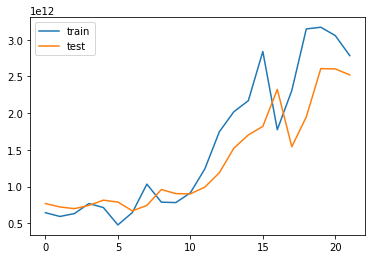

In [7]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(Ytest[:,0])],axis=1)
result.columns = ['Predicted','Actual']
result['diff'] = result['Predicted'] - result['Actual']
result
pyplot.plot(result['Actual'], label='train')
pyplot.plot(result['Predicted'], label='test')
pyplot.legend()
pyplot.show()